## Ex.04: CMB map-making
### Due: 20 Nov

In this notebook, you will crate your own simulated CMB map (on a flat-sky patch). There are three parts of this notebook. In the first part, have a look at the example codes below, where a map is created from a power-law spectrum of the form $C(\ell) \propto \ell^n$. We need to use the two-diemnsional fast-fourier transform, or FFT2, to go from the harmonic space to real space. For this we can employ the fft2 functionality in Numpy. 

The tasks for this exercise sheet follow after the code examples.

In [1]:
import numpy as np  # numerical routines
import matplotlib   # plotting libraries
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

## ipython notebook magic word to plot in the notebook
%matplotlib inline

## extra goody for controling colorbar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

First we create an empty map 5x5 degrees across and with pixel size 0.5 arcmin. Thus the map will contain 600x600 pixels.

In [2]:
map_size = 5.*60.   # map size in arcminutes
pixel_size = 0.5     # pixel size in arcminutes
N = int(map_size/pixel_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)


We create an arbitrary angular power spectrum of the form $C(\ell) = A\,\ell^n$. We then convert it into the plane harmonics by using $\ell = \pi/\theta$ (we are basically using $k=\sqrt{k_x^2+k_y^2}$ instead of $\ell$, and $k\sim 1/\theta$). Then we will make a 2D map in the Fourier plane.

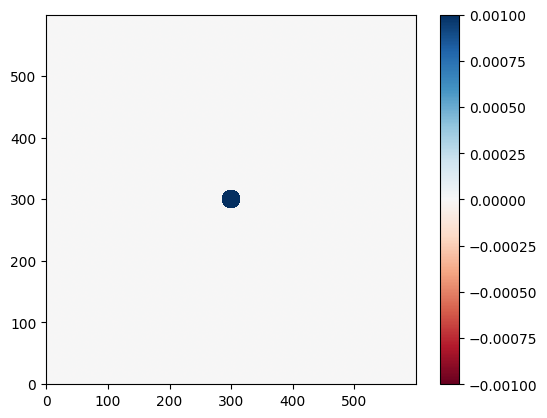

In [3]:
## create an ell-vector of arbitrary length
ell = np.arange(999, dtype=float)
 
A = 1.      # an arbitrary constant to normalize the power spectrum
ind = 0  # power-law index


## we have a power-law spectrum
Cl = A*(ell**ind)
## let us put the monopole and dipole terms explicitly to zero
Cl[0] = 0.
Cl[1] = 0.

## let's re-normalize this such that any power law will give similar amplitude at l=200
## as with the l^0 (flat) power spectrum (good for plot visibility)
Cl *= 1.0/Cl[199]


## we have to map the real-space vector R to Fourier-space vector ell
pix_to_rad = (pixel_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D

## The values in the array ell2d corresponds to the harmonic frequencies (recall l ~ 2pi/theta)
## we need an array that goes to this maximum number of multipoles (far exceeding our array dimension N)
## but most of the elemnts in this extended array will be zero!

Cl_expanded = np.zeros(int(ell2d.max())+1)
Cl_expanded[0:(Cl.size)] = Cl  # fill in the Cls until the max of the Cl vector
#print(Cl_expanded.shape)

## Now we need to extract the part of this array that corresponds to the values of ell2d (as integers).
## This is the 2D version of our 1D Cl power spectrum, whose dimensions are defined by 
## our choice of the pixel scale

Cl2d = Cl_expanded[ell2d.astype(int)]
#print(ell2d.astype(int).shape)


im = plt.imshow(Cl2d, interpolation='bilinear', origin='lower', cmap='RdBu')
im.set_clim(-0.001,0.001)
cbar = plt.colorbar()
plt.show()

The final part is Fourier transforming this 2D map, which we will do with the fft2 routine. Remember that the origin gets shifted in this transform, which we will fix with the fftshift argument, and that we only need to plot the real part. Also recall that we need to take the square root of the power spectrum, since it is temperature squared, before we fourier transform the $C_\ell$-map.

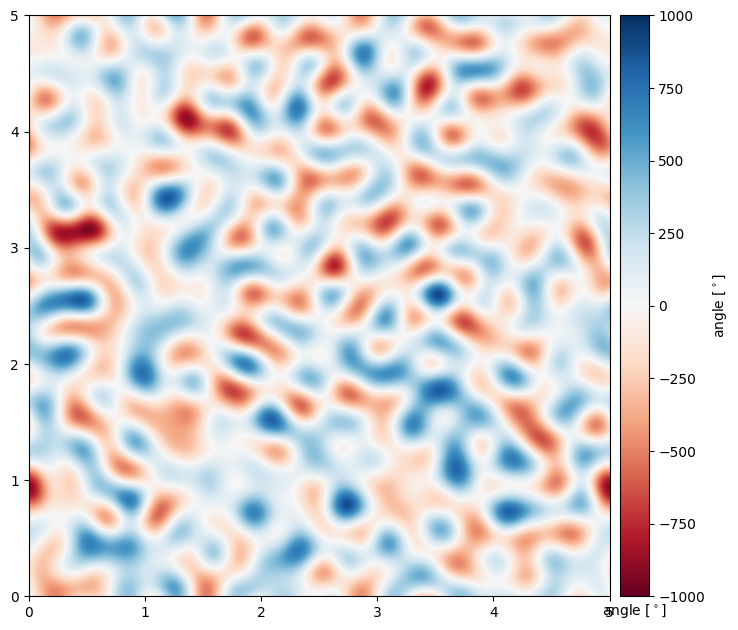

In [4]:
## We are creating a Gaussian random field, so our basis map will be an array of normally distributed random variables. 
## Onto this array we multiply with our 2D Cl array (square root of it)
## Note: If we have chosen Cl ~ l^0, then, of course, we will Fourier transform this random map.

random_map_array = np.random.normal(0,1,(N,N))
FT_random_array = np.fft.fft2(random_map_array)   # take FFT since Cl2D is in Fourier space 
    
FT_2d = np.sqrt(Cl2d) * FT_random_array     # we take the sqrt since the power spectrum is T^2
    

# now move back from the harmonic space to real space
map2d = np.fft.ifft2(np.fft.fftshift(FT_2d)) 

# rescaling map for change of variable of pixels to radians
map2d = map2d / pix_to_rad

# we only want to plot the real component
map2d = np.real(map2d)



## Plotting will require setting up the axis values according to the pixel size

im = plt.imshow(map2d, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim(-1000,1000)
X_width = N*pixel_size/60.  # horizontal map width in degrees
Y_width = N*pixel_size/60.  # vertical map width in degrees

# plotting details
plt.gcf().set_size_inches(8,8)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
plt.show()

## Task 1:
Change the slope of the power-law in the above example. What qualitative changes do you see in the map?

 the choice of the power-law slope influences the distribution of power across different scales, affecting the patterns and fluctuations observed in the map. Negative slopes emphasize larger scales, while positive slopes highlight smaller scales. The "redness" or "blueness" of the spectrum describes the relative power at different multipoles, with "red" indicating a preference for larger scales and "blue" for smaller scales. The natural "redness" of the CMB spectrum is influenced by physical processes like Silk damping, and adjusting the range of multipoles can further modify the perceived color of the spectrum.

When the power-law has a negative slope, it means that smaller values of 
k (associated with larger scales) are getting more emphasis. This results in larger, connected regions on the map with similar amplitudes because the power is distributed to these larger scales. As the power-law slope decreases even further, the influence of higher order modes on smaller scales diminishes. This results in the suppression of small fluctuations, making the map smoother on small scales.

Positive slopes in the power-law mean that smaller scales are emphasized. This increases the contrast in the map, as more attention is given to smaller features. 

## Task 2:

Download a CMB power-spectrum file from the CAMB online interface:

https://lambda.gsfc.nasa.gov/toolbox/camb_online.html

(or use the one from the Data_Files directory). Make a plot of the angular power spectrum using this file.

$\it Hint:$ You will need only the first two columns, $\ell$ vs the temperature anisotropy power. The temperature anisotropies are provided as $D_\ell$ (unit $\mu$K$^2$), as is traditionally plotted, where $D_\ell = \ell(\ell+1)/2\pi\; C_\ell$. You need to work with the $C_\ell$, which is the actual autocorrelation power.

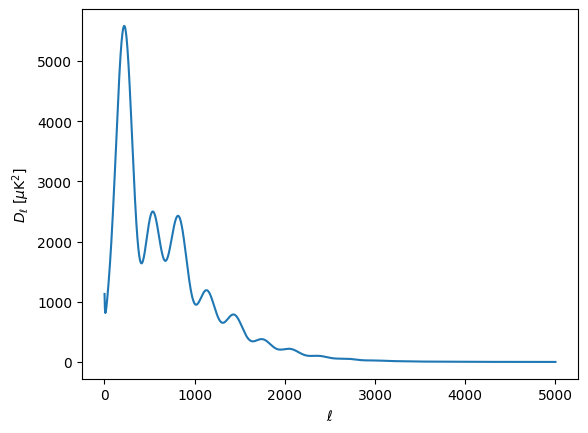

In [5]:
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalClsdat.sec", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

## Task 3:

Now make a map of the CMB using the above angular power spectrum. Note that the map will be in temperature units ($\mu$K). 

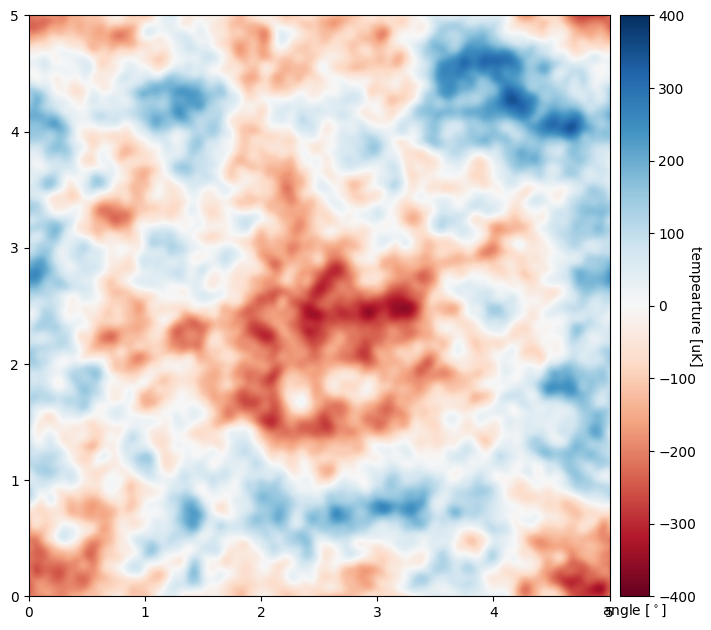

In [6]:
## convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.


## create map array
map_size = 5.*60.   # map size in arcminutes
pix_size = 0.5     # pixel size in arcminutes
N = int(map_size/pix_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)

pix_to_rad = (pix_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D


## create 2D power spectrum
ClTT_expanded = np.zeros(int(ell2d.max())+1)
ClTT_expanded[0:(ClTT.size)] = ClTT  # fill in the Cls until the max of the ClTT vector
ClTT2d = ClTT_expanded[ell2d.astype(int)]


## make random realization of a Gaussian field and Fourier transform
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    
    
# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/pix_to_rad
# we only want to plot the real component
CMB_T = np.real(CMB_T)


## plot the CMB map
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees

im = plt.imshow(CMB_T, origin='lower', interpolation='bilinear', cmap='RdBu')

plt.gcf().set_size_inches(8,8)
im.set_clim(c_min,c_max)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
cbar.set_label('tempearture [uK]', rotation=270)

plt.show()

### <font color='red'> Bonus task: </font>

Set the power to zero to either high-ell part or the low-ell part of the power spectrum. What difference do you notice in the created CMB map?

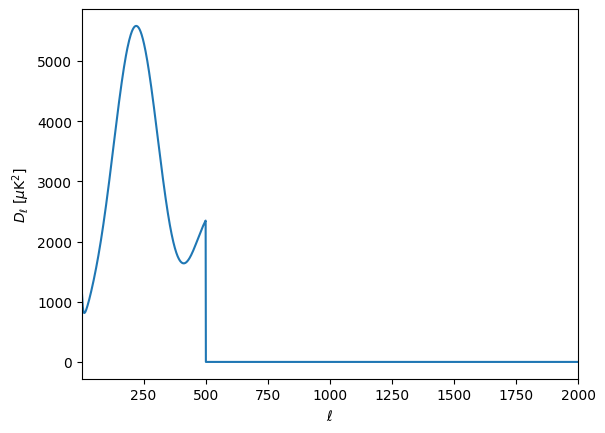

In [7]:
## arbitraruly modifying the power spectrum
ell, DlTT2 = np.loadtxt("CAMB_fiducial_cosmo_scalClsdat.sec", usecols=(0, 1), unpack=True)

# setting ell>500 to zero
DlTT2[499:] = 0.0

plt.plot(ell,DlTT2)
plt.xlim(2,2000)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

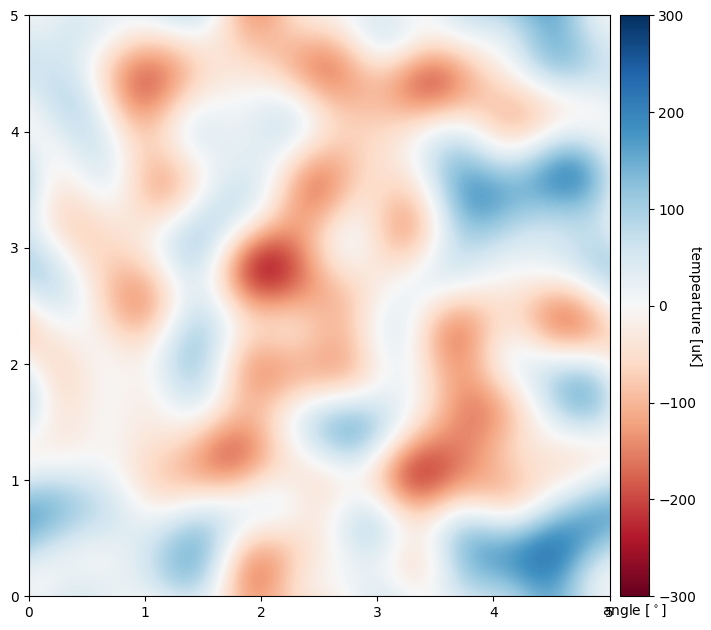

In [8]:
## convert Dl to Cl
ClTT = DlTT2 * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.


## create map array
map_size = 5.*60.   # map size in arcminutes
pix_size = 0.5     # pixel size in arcminutes
N = int(map_size/pix_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)

pix_to_rad = (pix_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D


## create 2D power spectrum
ClTT_expanded = np.zeros(int(ell2d.max())+1)
ClTT_expanded[0:(ClTT.size)] = ClTT  # fill in the Cls until the max of the ClTT vector
ClTT2d = ClTT_expanded[ell2d.astype(int)]


## make random realization of a Gaussian field and Fourier transform
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    
    
# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/pix_to_rad
# we only want to plot the real component
CMB_T = np.real(CMB_T)


## plot the CMB map
c_min = -300  # minimum for color bar
c_max = 300   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees

im = plt.imshow(CMB_T, origin='lower', interpolation='bilinear', cmap='RdBu')

plt.gcf().set_size_inches(8,8)
im.set_clim(c_min,c_max)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
cbar.set_label('tempearture [uK]', rotation=270)

plt.show()

If we cut off at the high-l, then it becomes "redder". It means you are essentially removing or significantly reducing the contribution of small-scale fluctuations. The resulting CMB map exhibits a smoother appearance with fewer details at smaller scales.
Features associated with high-l modes, such as fine-scale temperature fluctuations, would be suppressed or absent.

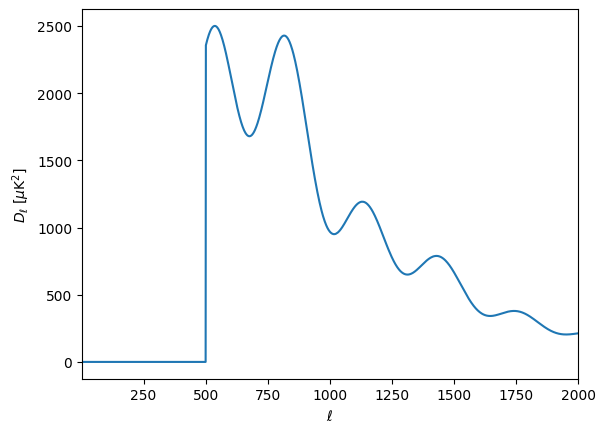

In [9]:
## arbitraruly modifying the power spectrum
ell, DlTT3 = np.loadtxt("CAMB_fiducial_cosmo_scalClsdat.sec", usecols=(0, 1), unpack=True)

# setting ell>500 to zero
DlTT3[:499] = 0.0

plt.plot(ell,DlTT3)
plt.xlim(2,2000)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

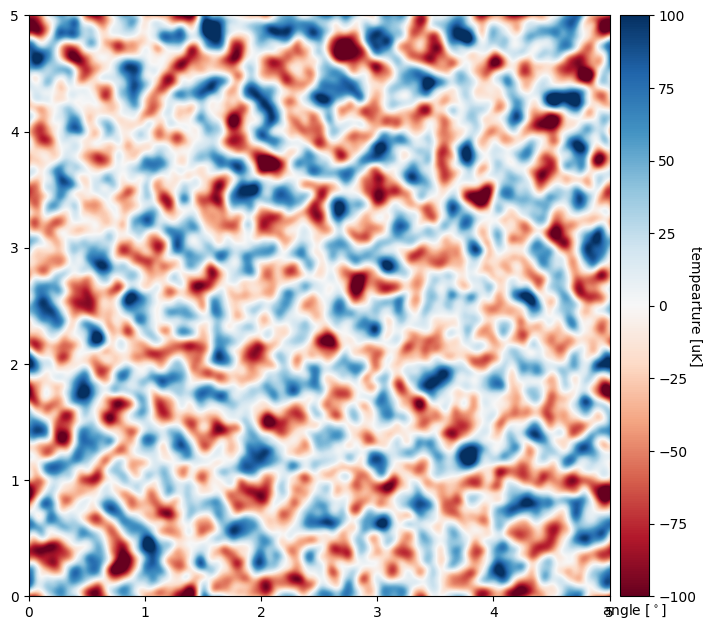

In [10]:
## convert Dl to Cl
ClTT = DlTT3 * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.


## create map array
map_size = 5.*60.   # map size in arcminutes
pix_size = 0.5     # pixel size in arcminutes
N = int(map_size/pix_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)

pix_to_rad = (pix_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D


## create 2D power spectrum
ClTT_expanded = np.zeros(int(ell2d.max())+1)
ClTT_expanded[0:(ClTT.size)] = ClTT  # fill in the Cls until the max of the ClTT vector
ClTT2d = ClTT_expanded[ell2d.astype(int)]


## make random realization of a Gaussian field and Fourier transform
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    
    
# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/pix_to_rad
# we only want to plot the real component
CMB_T = np.real(CMB_T)


## plot the CMB map
c_min = -100  # minimum for color bar
c_max = 100   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees

im = plt.imshow(CMB_T, origin='lower', interpolation='bilinear', cmap='RdBu')

plt.gcf().set_size_inches(8,8)
im.set_clim(c_min,c_max)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
cbar.set_label('tempearture [uK]', rotation=270)

plt.show()

CMB map lose its larger-scale features, and the overall structure might appear more dominated by small-scale fluctuations. It essentially becomes "bluer".